### Downloading MNIST using torchvision

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, sampler
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.utils


import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.image as mpimg
import PIL
import random as rnd
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd

import sys
# np.set_printoptions(threshold=sys.maxsize)

np.random.seed(42)


In [ ]:
train_examples = 100
test_examples = 10
epochs = 15
batch_size = 50

(<PIL.Image.Image image mode=L size=28x28 at 0x7F185BBDDDD0>, 0)
<PIL.Image.Image image mode=L size=28x28 at 0x7F185BBDD450> 2


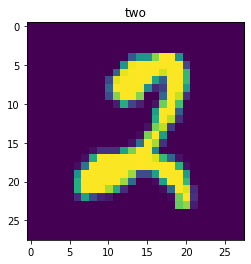

In [ ]:
dataset = torchvision.datasets.MNIST(root='./',download=True)
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

labels_map = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine",
}

train_indices = np.zeros((10, train_examples))
test_indices = np.zeros((10, test_examples))
train_labels = np.array(trainset.targets)
test_labels = np.array(testset.targets)

# taking first 100 images of each class
for i in range(10):
  train_idx = np.where(train_labels == i)[0]
  test_idx = np.where(test_labels == i)[0]

  train_indices[i] = np.array(train_idx[0:train_examples])
  test_indices[i] = np.array(test_idx[0:test_examples])

train_indices = train_indices.astype(int)
test_indices = test_indices.astype(int)

train_indices_flat = train_indices.flatten()
test_indices_flat = test_indices.flatten()

# print(train_indices.shape)


print(dataset[train_indices[0, 0]])

train_data = []
test_data = []
for i in range(10):
  for j in range(train_examples):
    I, label = dataset[train_indices[i, j]]
    I = np.array(I)
    train_data.append([I, label])
  for j in range(test_examples):
    I, label = dataset[test_indices[i, j]]
    I = np.array(I)
    test_data.append([I, label])


# train_indices_flat = torch.tensor(train_indices_flat, dtype=torch.int)
trainset = torch.utils.data.Subset(trainset, train_indices_flat)

# test_indices_flat = torch.tensor(test_indices_flat, dtype=torch.int)
testset = torch.utils.data.Subset(testset, test_indices_flat)

sample_idx = torch.randint(len(dataset), size=(1,)).item()
img, label = dataset[sample_idx]
print(img, label)
plt.title(labels_map[label])
plt.imshow(img)

I = np.array(img)

ground_truth = np.identity(10)

# PyTorch

## Config

In [ ]:
class Config():
    batch_size = 50
    epochs = 15
    lr = 0.001
    eta = 0.001
    alpha = 0.9
    rho = 0.9    

## Dataloaders

In [ ]:
train_dataloader = DataLoader(trainset, shuffle=True, batch_size=Config.batch_size)
test_dataloader = DataLoader(testset, shuffle=True, batch_size=Config.batch_size)

## Graph Loss

In [ ]:
def plot_loss(train_loss, test_loss, graph_title):
  plt.plot(train_loss, label="Training Loss")
  plt.plot(test_loss, label="Test Loss")
  plt.title(graph_title)
  plt.xlabel("Epoch")
  plt.ylabel("Cross Entropy Loss")
  plt.legend()
  plt.show()

## Model

In [ ]:
# Model
class CNN(nn.Module):
  def __init__(self, dropout_status=False, p=0.2, batch_norm=False):

    super(CNN, self).__init__()
    self.dropout_status = dropout_status
    self.batch_norm = batch_norm


    # first conv layer
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(5, 5))
    self.relu1 = nn.ReLU()

    # first maxpooling layer
    self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # second conv layer
    self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=(5, 5))
    self.relu2 = nn.ReLU()

    # second maxpooling layer
    self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
    
    # MLP first layer
    self.fc1 = nn.Linear(in_features=64, out_features=49)
    self.relu3 = nn.ReLU()

    self.dropout = nn.Dropout(p=p)
    self.batchNorm = nn.BatchNorm1d(49)

    # MLP hidden layer
    self.fc2 = nn.Linear(in_features=49, out_features=10)
    self.logSoftmax = nn.LogSoftmax(dim=1)

    

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu1(x)

    x = self.maxpool1(x)
    
    x = self.conv2(x)
    x = self.relu2(x)

    x = self.maxpool2(x)
    
    bottleneck = torch.flatten(x, 1)
    
    x = self.fc1(bottleneck)

    if self.batch_norm == True:
      x = self.batchNorm(x)

    x = self.relu3(x)

    if self.dropout_status == True:
      x = self.dropout(x)

    x = self.fc2(x)
    output = self.logSoftmax(x)
    return output, bottleneck

## t-SNE

In [ ]:
# The assignment document mentioned we are allowed to use open source code for the t-SNE plots.
# Hence, the t-SNE code was referenced from the following website: 
# https://www.datatechnotes.com/2020/11/tsne-visualization-example-in-python.html

def plot_tsne(values, plot_title, state):
  # flatten_values, labels,
  flatten_values = np.zeros((len(values) * Config.batch_size, len(values[0][0][0])))
  labels = np.zeros(len(values) * Config.batch_size)
  index = 0
  for i in range(len(values)):
    for j in range(len(values[i][0])):
        flatten_values[index] = values[i][0][j].detach().numpy()
        labels[index] = values[i][1][j].detach().numpy()
        index += 1

  tsne = TSNE(n_components=2, random_state=state)
  z = tsne.fit_transform(flatten_values)
  df = pd.DataFrame()
  df["labels"] = labels
  df["comp-1"] = z[:,0]
  df["comp-2"] = z[:,1]

  sns.scatterplot(x="comp-1", y="comp-2", hue=df.labels.tolist(), palette=sns.color_palette("hls", 10), data=df).set(title=plot_title)

## Train

In [ ]:
def train(optimizer="SGD", dropout_status=False, p=0.2, batch_norm=False):

  cnn = CNN(dropout_status=dropout_status, p=p, batch_norm=batch_norm)
  opt = {"SGD": torch.optim.SGD(cnn.parameters(), lr=Config.lr),
       "momentum": torch.optim.SGD(cnn.parameters(), lr=Config.lr, momentum=Config.alpha),
       "RMSProp": torch.optim.RMSprop(cnn.parameters(), lr=Config.lr, alpha=Config.rho)}
  # implementing cross entropy loss in combitnation with softmax
  crossEntropyLoss = nn.NLLLoss()  
  
  train_loss = []
  test_loss = []
  train_acc = []
  test_acc = []
  first_epoch_flatten = []
  last_epoch_flatten = []

  for epoch in range(Config.epochs):
    print("Epoch:", epoch)
    # train mode
    cnn.train()

    train_correct_matches = 0
    train_avg_loss = 0

    test_correct_matches = 0
    test_avg_loss = 0

    # train
    for (X, y) in train_dataloader:

      # forward pass
      pred, _ = cnn(X)
      loss = crossEntropyLoss(pred, y)

      # backward pass
      opt[optimizer].zero_grad() # zeroing gradient
      loss.backward() # backpropagation
      opt[optimizer].step()      # update weights

      train_avg_loss += loss
      train_correct_matches += (pred.argmax(1) == y).type(torch.float).sum().item()

    # test/val
    with torch.no_grad():
      cnn.eval()

      for (X, y) in test_dataloader:
        # forward pass
        pred, bottleneck = cnn(X)
        test_avg_loss += crossEntropyLoss(pred, y)
        test_correct_matches += (pred.argmax(1) == y).type(torch.float).sum().item()
        if epoch == 0:
          first_epoch_flatten.append([bottleneck, y])
        if epoch == Config.epochs - 1:
          last_epoch_flatten.append([bottleneck, y])

    train_avg_loss = ((train_avg_loss / len(train_dataloader.dataset)) * 100).detach().numpy()
    train_loss.append(train_avg_loss)
    test_avg_loss = ((test_avg_loss / len(test_dataloader.dataset)) * 100).detach().numpy()
    test_loss.append(test_avg_loss)

    train_correct_matches = (train_correct_matches / len(train_dataloader.dataset)) * 100
    train_acc.append(train_correct_matches)
    test_correct_matches = (test_correct_matches / len(test_dataloader.dataset)) * 100
    test_acc.append(test_correct_matches)

    print("Train Accuracy:", train_correct_matches)
    print("Train Loss:", train_avg_loss)
    print("Test Accuracy:", test_correct_matches)
    print("Test Loss:", test_avg_loss)
    print()

  return train_loss, test_loss, train_acc, test_acc, first_epoch_flatten, last_epoch_flatten

## Outputs

### Vanilla SGD

In [ ]:
SGD_train_loss, SGD_test_loss, SGD_train_acc, SGD_test_acc, SGD_first_epoch_flatten, SGD_last_epoch_flatten = train("SGD")

Epoch: 0
Train Accuracy: 10.0
Train Loss: 4.613689
Test Accuracy: 10.0
Test Loss: 4.6140413

Epoch: 1
Train Accuracy: 10.0
Train Loss: 4.613452
Test Accuracy: 10.0
Test Loss: 4.6138163

Epoch: 2
Train Accuracy: 10.0
Train Loss: 4.6132197
Test Accuracy: 10.0
Test Loss: 4.6135936

Epoch: 3
Train Accuracy: 10.0
Train Loss: 4.612999
Test Accuracy: 10.0
Test Loss: 4.6133747

Epoch: 4
Train Accuracy: 10.0
Train Loss: 4.6127567
Test Accuracy: 10.0
Test Loss: 4.6131573

Epoch: 5
Train Accuracy: 10.0
Train Loss: 4.6125364
Test Accuracy: 10.0
Test Loss: 4.612938

Epoch: 6
Train Accuracy: 10.0
Train Loss: 4.612298
Test Accuracy: 10.0
Test Loss: 4.612722

Epoch: 7
Train Accuracy: 10.0
Train Loss: 4.612076
Test Accuracy: 10.0
Test Loss: 4.612506

Epoch: 8
Train Accuracy: 10.0
Train Loss: 4.6118474
Test Accuracy: 10.0
Test Loss: 4.6122932

Epoch: 9
Train Accuracy: 10.0
Train Loss: 4.6116195
Test Accuracy: 10.0
Test Loss: 4.6120815

Epoch: 10
Train Accuracy: 10.0
Train Loss: 4.6113877
Test Accuracy: 

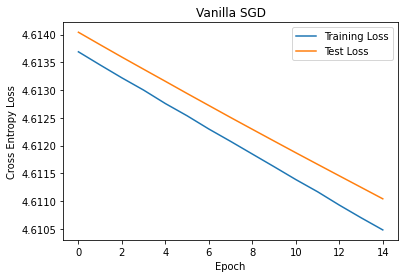

In [ ]:
plot_loss(SGD_train_loss, SGD_test_loss, "Vanilla SGD")

### Momentum

In [ ]:
Momentum_train_loss, Momentum_test_loss, Momentum_train_acc, Momentum_test_acc, Momentum_first_epoch_flatten, Momentum_last_epoch_flatten = train("momentum")

Epoch: 0
Train Accuracy: 7.5
Train Loss: 4.61338
Test Accuracy: 9.0
Test Loss: 4.612759

Epoch: 1
Train Accuracy: 8.200000000000001
Train Loss: 4.609646
Test Accuracy: 10.0
Test Loss: 4.60874

Epoch: 2
Train Accuracy: 9.8
Train Loss: 4.6055226
Test Accuracy: 13.0
Test Loss: 4.604556

Epoch: 3
Train Accuracy: 11.200000000000001
Train Loss: 4.601656
Test Accuracy: 13.0
Test Loss: 4.600466

Epoch: 4
Train Accuracy: 14.2
Train Loss: 4.597644
Test Accuracy: 13.0
Test Loss: 4.596656

Epoch: 5
Train Accuracy: 16.1
Train Loss: 4.593838
Test Accuracy: 18.0
Test Loss: 4.5932026

Epoch: 6
Train Accuracy: 17.2
Train Loss: 4.5900526
Test Accuracy: 22.0
Test Loss: 4.5896387

Epoch: 7
Train Accuracy: 19.8
Train Loss: 4.585942
Test Accuracy: 26.0
Test Loss: 4.5861073

Epoch: 8
Train Accuracy: 21.7
Train Loss: 4.5819817
Test Accuracy: 26.0
Test Loss: 4.5821943

Epoch: 9
Train Accuracy: 22.400000000000002
Train Loss: 4.5776253
Test Accuracy: 24.0
Test Loss: 4.577932

Epoch: 10
Train Accuracy: 23.3
Train

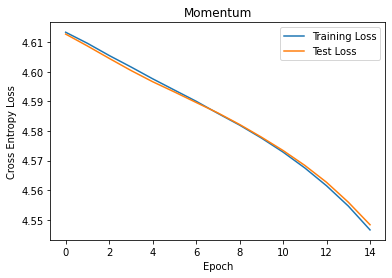

In [ ]:
plot_loss(Momentum_train_loss, Momentum_test_loss, "Momentum")

### RMS Prop

#### Without Dropout

In [ ]:
RMS_train_loss, RMS_test_loss, RMS_train_acc, RMS_test_acc, RMS_first_epoch_flatten, RMS_last_epoch_flatten = train("RMSProp")

Epoch: 0
Train Accuracy: 13.4
Train Loss: 4.570903
Test Accuracy: 28.999999999999996
Test Loss: 4.473941

Epoch: 1
Train Accuracy: 39.6
Train Loss: 4.219077
Test Accuracy: 44.0
Test Loss: 3.8149047

Epoch: 2
Train Accuracy: 64.9
Train Loss: 3.2711785
Test Accuracy: 71.0
Test Loss: 2.6769829

Epoch: 3
Train Accuracy: 72.89999999999999
Train Loss: 2.283785
Test Accuracy: 70.0
Test Loss: 1.9361141

Epoch: 4
Train Accuracy: 77.3
Train Loss: 1.7180879
Test Accuracy: 76.0
Test Loss: 1.4926894

Epoch: 5
Train Accuracy: 79.9
Train Loss: 1.4165995
Test Accuracy: 83.0
Test Loss: 1.2730436

Epoch: 6
Train Accuracy: 81.8
Train Loss: 1.2391672
Test Accuracy: 82.0
Test Loss: 1.1135697

Epoch: 7
Train Accuracy: 83.3
Train Loss: 1.1239275
Test Accuracy: 84.0
Test Loss: 0.97724724

Epoch: 8
Train Accuracy: 85.39999999999999
Train Loss: 1.0210005
Test Accuracy: 84.0
Test Loss: 0.88387346

Epoch: 9
Train Accuracy: 86.4
Train Loss: 0.9602739
Test Accuracy: 87.0
Test Loss: 0.92312723

Epoch: 10
Train Accur

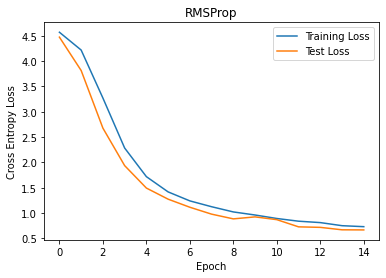

In [ ]:
plot_loss(RMS_train_loss, RMS_test_loss, "RMSProp")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


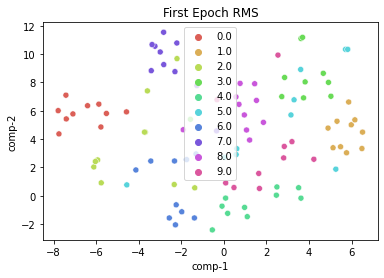

In [ ]:
plot_tsne(RMS_first_epoch_flatten, "First Epoch RMS", 41)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


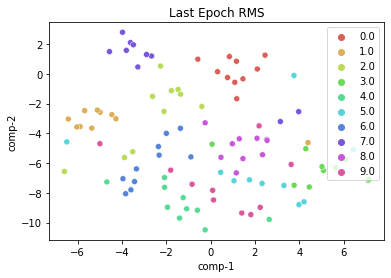

In [ ]:
plot_tsne(RMS_last_epoch_flatten, "Last Epoch RMS", 40)

#### With Dropout (dropout rate = 0.2)

In [ ]:
D_RMS_train_loss, D_RMS_test_loss, D_RMS_train_acc, D_RMS_test_acc, D_RMS_first_epoch_flatten, D_RMS_last_epoch_flatten = train("RMSProp", dropout_status=True, p=0.2)

Epoch: 0
Train Accuracy: 13.100000000000001
Train Loss: 4.5708127
Test Accuracy: 27.0
Test Loss: 4.480489

Epoch: 1
Train Accuracy: 36.0
Train Loss: 4.289008
Test Accuracy: 52.0
Test Loss: 3.9771893

Epoch: 2
Train Accuracy: 51.4
Train Loss: 3.6024942
Test Accuracy: 60.0
Test Loss: 3.1602302

Epoch: 3
Train Accuracy: 60.699999999999996
Train Loss: 2.8240397
Test Accuracy: 70.0
Test Loss: 2.414373

Epoch: 4
Train Accuracy: 66.7
Train Loss: 2.2636578
Test Accuracy: 72.0
Test Loss: 1.9482054

Epoch: 5
Train Accuracy: 70.5
Train Loss: 1.9368595
Test Accuracy: 73.0
Test Loss: 1.6755191

Epoch: 6
Train Accuracy: 74.5
Train Loss: 1.6833141
Test Accuracy: 75.0
Test Loss: 1.4833755

Epoch: 7
Train Accuracy: 75.3
Train Loss: 1.4861557
Test Accuracy: 79.0
Test Loss: 1.2650077

Epoch: 8
Train Accuracy: 78.7
Train Loss: 1.364101
Test Accuracy: 85.0
Test Loss: 1.1280453

Epoch: 9
Train Accuracy: 79.10000000000001
Train Loss: 1.318062
Test Accuracy: 82.0
Test Loss: 1.1279819

Epoch: 10
Train Accuracy

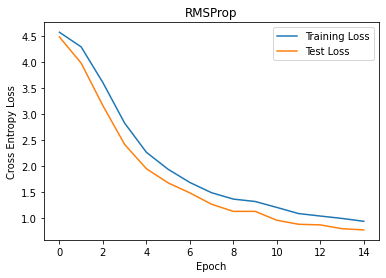

In [ ]:
plot_loss(D_RMS_train_loss, D_RMS_test_loss, "RMSProp")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


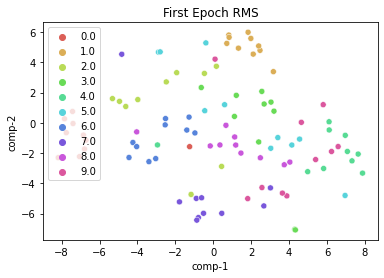

In [ ]:
plot_tsne(D_RMS_first_epoch_flatten, "First Epoch RMS", 41)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


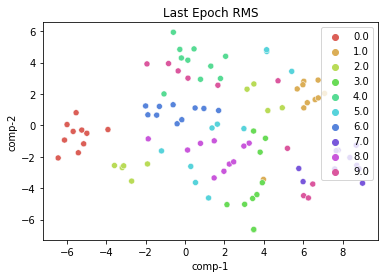

In [ ]:
plot_tsne(D_RMS_last_epoch_flatten, "Last Epoch RMS", 40)

#### With Dropout (dropout rate = 0.5)

In [ ]:
D_RMS_train_loss, D_RMS_test_loss, D_RMS_train_acc, D_RMS_test_acc, D_RMS_first_epoch_flatten, D_RMS_last_epoch_flatten = train("RMSProp", dropout_status=True, p=0.5)

Epoch: 0
Train Accuracy: 17.1
Train Loss: 4.5407643
Test Accuracy: 45.0
Test Loss: 4.408128

Epoch: 1
Train Accuracy: 30.9
Train Loss: 4.2207556
Test Accuracy: 54.0
Test Loss: 3.8970582

Epoch: 2
Train Accuracy: 38.0
Train Loss: 3.70754
Test Accuracy: 64.0
Test Loss: 3.2371492

Epoch: 3
Train Accuracy: 49.3
Train Loss: 3.1686907
Test Accuracy: 70.0
Test Loss: 2.6709442

Epoch: 4
Train Accuracy: 56.00000000000001
Train Loss: 2.7690182
Test Accuracy: 74.0
Test Loss: 2.2700925

Epoch: 5
Train Accuracy: 61.3
Train Loss: 2.4111037
Test Accuracy: 71.0
Test Loss: 1.9860563

Epoch: 6
Train Accuracy: 65.4
Train Loss: 2.2151968
Test Accuracy: 76.0
Test Loss: 1.7523179

Epoch: 7
Train Accuracy: 68.0
Train Loss: 2.0303295
Test Accuracy: 74.0
Test Loss: 1.6126

Epoch: 8
Train Accuracy: 68.89999999999999
Train Loss: 1.8831912
Test Accuracy: 79.0
Test Loss: 1.4589866

Epoch: 9
Train Accuracy: 70.6
Train Loss: 1.760898
Test Accuracy: 79.0
Test Loss: 1.3907349

Epoch: 10
Train Accuracy: 72.8
Train Loss

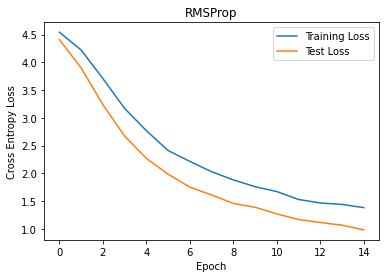

In [ ]:
plot_loss(D_RMS_train_loss, D_RMS_test_loss, "RMSProp")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


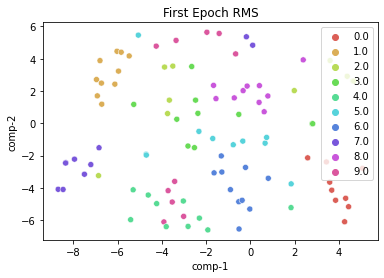

In [ ]:
plot_tsne(D_RMS_first_epoch_flatten, "First Epoch RMS", 41)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


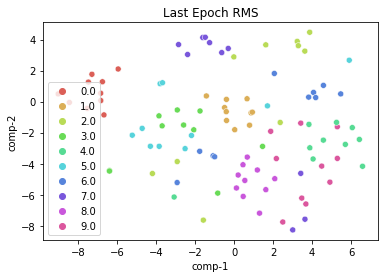

In [ ]:
plot_tsne(D_RMS_last_epoch_flatten, "Last Epoch RMS", 40)

#### With Dropout (dropout rate = 0.8)

In [ ]:
D_RMS_train_loss, D_RMS_test_loss, D_RMS_train_acc, D_RMS_test_acc, D_RMS_first_epoch_flatten, D_RMS_last_epoch_flatten = train("RMSProp", dropout_status=True, p=0.8)

Epoch: 0
Train Accuracy: 10.0
Train Loss: 4.60883
Test Accuracy: 11.0
Test Loss: 4.600339

Epoch: 1
Train Accuracy: 11.1
Train Loss: 4.5975547
Test Accuracy: 14.000000000000002
Test Loss: 4.577361

Epoch: 2
Train Accuracy: 13.8
Train Loss: 4.544061
Test Accuracy: 26.0
Test Loss: 4.4979053

Epoch: 3
Train Accuracy: 19.5
Train Loss: 4.4193974
Test Accuracy: 45.0
Test Loss: 4.3123446

Epoch: 4
Train Accuracy: 23.7
Train Loss: 4.248129
Test Accuracy: 51.0
Test Loss: 4.0422354

Epoch: 5
Train Accuracy: 28.000000000000004
Train Loss: 4.04045
Test Accuracy: 60.0
Test Loss: 3.7214108

Epoch: 6
Train Accuracy: 29.099999999999998
Train Loss: 3.8202755
Test Accuracy: 64.0
Test Loss: 3.4503057

Epoch: 7
Train Accuracy: 35.6
Train Loss: 3.6167428
Test Accuracy: 65.0
Test Loss: 3.1574721

Epoch: 8
Train Accuracy: 38.0
Train Loss: 3.4871974
Test Accuracy: 67.0
Test Loss: 2.9590893

Epoch: 9
Train Accuracy: 39.1
Train Loss: 3.31222
Test Accuracy: 69.0
Test Loss: 2.7127132

Epoch: 10
Train Accuracy: 39

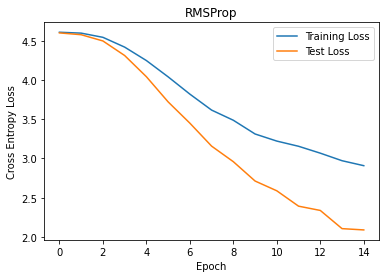

In [ ]:
plot_loss(D_RMS_train_loss, D_RMS_test_loss, "RMSProp")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


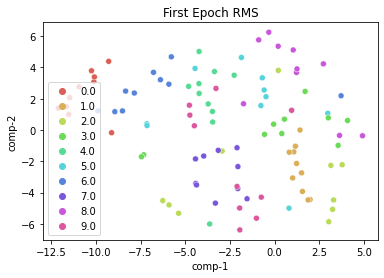

In [ ]:
plot_tsne(D_RMS_first_epoch_flatten, "First Epoch RMS", 41)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


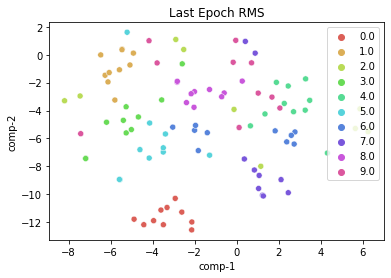

In [ ]:
plot_tsne(D_RMS_last_epoch_flatten, "Last Epoch RMS", 40)

#### Observations
It is clear that as the drop out rate increases, the accuracy decreases. Moreover, without drop out, the accuracy was the highest, at an 89%.

#### With Dropout + Bath Normalisation

In [ ]:
BN_RMS_train_loss, BN_RMS_test_loss, BN_RMS_train_acc, BN_RMS_test_acc, BN_RMS_first_epoch_flatten, BN_RMS_last_epoch_flatten = train("RMSProp", dropout_status=True, p=0.2, batch_norm=True)

Epoch: 0
Train Accuracy: 32.800000000000004
Train Loss: 4.0586605
Test Accuracy: 32.0
Test Loss: 4.386055

Epoch: 1
Train Accuracy: 60.9
Train Loss: 3.1573172
Test Accuracy: 65.0
Test Loss: 3.613176

Epoch: 2
Train Accuracy: 73.2
Train Loss: 2.603298
Test Accuracy: 75.0
Test Loss: 2.396419

Epoch: 3
Train Accuracy: 80.4
Train Loss: 2.1110046
Test Accuracy: 80.0
Test Loss: 1.8560655

Epoch: 4
Train Accuracy: 82.69999999999999
Train Loss: 1.8181611
Test Accuracy: 79.0
Test Loss: 1.6494386

Epoch: 5
Train Accuracy: 85.5
Train Loss: 1.5420663
Test Accuracy: 85.0
Test Loss: 1.4965668

Epoch: 6
Train Accuracy: 87.9
Train Loss: 1.27742
Test Accuracy: 87.0
Test Loss: 1.1988103

Epoch: 7
Train Accuracy: 89.60000000000001
Train Loss: 1.0992877
Test Accuracy: 89.0
Test Loss: 1.082037

Epoch: 8
Train Accuracy: 91.0
Train Loss: 0.9370082
Test Accuracy: 88.0
Test Loss: 1.0651431

Epoch: 9
Train Accuracy: 92.30000000000001
Train Loss: 0.85460395
Test Accuracy: 91.0
Test Loss: 0.81162655

Epoch: 10
Tr

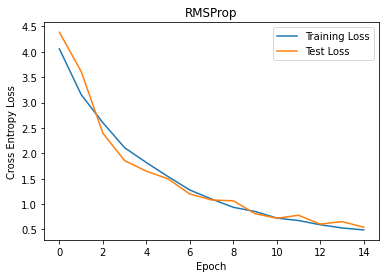

In [ ]:
plot_loss(BN_RMS_train_loss, BN_RMS_test_loss, "RMSProp")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


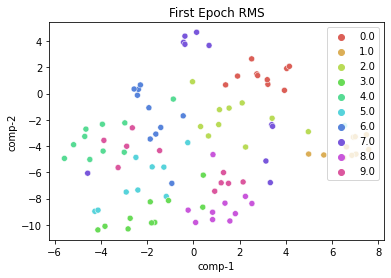

In [ ]:
plot_tsne(BN_RMS_first_epoch_flatten, "First Epoch RMS", 44)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


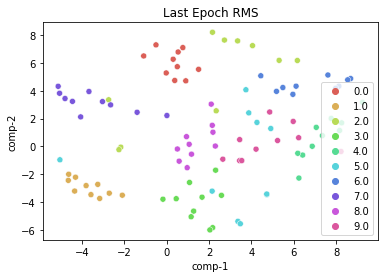

In [ ]:
plot_tsne(BN_RMS_last_epoch_flatten, "Last Epoch RMS", 45)

#### Observations
However, when we combine bath normalisation with dropout, the accuracy increases beyond what we got with no dropout or batch normalisation.

# Non-Pytorch

### Activation Functions

In [95]:
def sigmoid(I):
  I = -1 * I
  return 1/(1 + np.exp(I))

In [96]:
def reLU(I):
  I[I < 0] = 0
  return I

In [97]:
def tanh(I):
  return (np.exp(I) - np.exp(-1 * I))/(np.exp(I) + np.exp(-1 * I))

In [98]:
def PreLU(I, a=0.01):
  I[I <= 0] = a * I[I <= 0]
  return I

### Convolution 

In [99]:
def convolution1(I, kernel, padding=True, stride=1, activation='relu'):

  N1, M1 = I.shape
  N2, M2 = kernel.shape

  if padding == True:
    padding = N2 // 2
    # zero padding
    padded = np.zeros((N1 + padding * 2, M1 + padding * 2))
    padded[padding:-padding, padding:-padding] = I
  else:
    padding = 0
    padded = I

  result = np.zeros((int((N1 - N2 + 2 * padding)/stride + 1), int((M1 - M2 + 2 * padding)/stride + 1)))

  # for faster calculations
  for i in range(padding, N1 + padding):
    if i % stride == 0:
      for j in range(padding, M1 + padding):
        if j % stride == 0:
          # handling odd and even sized kernels
          if N2 % 2 != 0:
            result[i - padding, j - padding] = (np.multiply(kernel, padded[i - padding: i + padding + 1, j - padding: j + padding + 1]).sum())
          else:
            result[i - padding, j - padding] = (np.multiply(kernel, padded[i - padding: i + padding, j - padding: j + padding]).sum())

  # getting rid of the bottom right extra padding in case of even-sized kernels
  if N2 % 2 == 0:
    result = result[0:N1, 0:M1]


  if activation == 'sigmoid':
    result = sigmoid(result) 
  elif activation == 'relu':
    result = reLU(result)
  elif activation == 'prelu':
    result = PreLU(result) 
  elif activation == 'tanh':
    result = tanh(result) 

  gradient_relu = np.zeros(result.shape)
  gradient_relu = result > 0
  gradient_relu = gradient_relu.astype(int)
  
  return result, gradient_relu

In [100]:
def convolution2(I, kernel, padding=True, stride=1, activation='relu'):

  _, N1, M1 = I.shape
  _, N2, M2 = kernel.shape


  if padding == True:
    padding = N2 // 2
    # zero padding
    padded = np.zeros((I.shape[0], N1 + padding * 2, M1 + padding * 2))
    for i in range(I.shape[0]):
      padded[i, padding:-padding, padding:-padding] = I[i, :, :]
  else:
    padding = 0
    padded = np.zeros((I.shape[0], N1 + padding * 2, M1 + padding * 2))
    padded = I.copy()
  

  result = np.zeros((int((N1 - N2 + 2 * padding)/stride + 1), int((M1 - M2 + 2 * padding)/stride + 1)))

    
  # for faster calculations
  for i in range(padding, N1 + padding):
    if i % stride == 0:
      for j in range(padding, M1 + padding):
        if j % stride == 0:
          # handling odd and even sized kernels
          if N2 % 2 != 0:
            result[i - padding, j - padding] = (np.multiply(kernel, padded[:, i - padding: i + padding + 1, j - padding: j + padding + 1]).sum())
          else:
            result[i - padding, j - padding] = (np.multiply(kernel, padded[:, i - padding: i + padding, j - padding: j + padding]).sum())

  # getting rid of the bottom right extra padding in case of even-sized kernels
  if N2 % 2 == 0:
    result = result[0:N1, 0:M1]

  if activation == 'sigmoid':
    result = sigmoid(result) 
  elif activation == 'relu':
    result = reLU(result)
  elif activation == 'prelu':
    result = PreLU(result) 
  elif activation == 'tanh':
    result = tanh(result) 

  gradient_relu = np.zeros(result.shape)
  gradient_relu = result > 0
  gradient_relu = gradient_relu.astype(int)
  
  return result, gradient_relu

###Kernels

In [101]:
def randomKernel1(kernel_size):
  M = np.random.random((kernel_size, kernel_size))
  # kernel = [M, M, M]
  kernel = M
  kernel = np.array(M)
  kernel = kernel / kernel.sum()
  return kernel

def randomKernel2(kernel_size):
  M = np.random.random((kernel_size, kernel_size))
  # stack 16 times
  kernel = [M, M, M, M]
  kernel = np.array(kernel)
  kernel = kernel / kernel.sum()
  return kernel

### Pooling 

In [102]:
def pooling(I, pool_size, stride=2, poolType='max'):

  height, width = I.shape

  heightRes = int((height - pool_size)/stride + 1)
  widthRes = int((width - pool_size)/stride + 1)
  output = np.zeros((heightRes, widthRes))
  mask_indices = np.zeros(output.shape, dtype=(np.int64, 2))

  for i in range(0, height, stride):
    if i + pool_size > height:
      break
    for j in range(0, width, stride):
      if j + pool_size > width:
        break
      temp = I[i : i + pool_size, j : j + pool_size]
      output[int(i/stride), int(j/stride)] = np.amax(temp)
      index = np.unravel_index(np.argmax(I[i : i + pool_size, j : j + pool_size]), I[i : i + pool_size, j : j + pool_size].shape)
      index = np.array(index)
      index[0] = index[0] + i
      index[1] = index[1] + j
      mask_indices[int(i/stride), int(j/stride)] = index
  return output, mask_indices

In [103]:
def pooling_backward(shape, mask_indices, gradients):
  output = np.zeros(shape)
  index = 0
  for i in range(gradients.shape[0]):
    for j in range(gradients.shape[1]):
      x, y = mask_indices[index]
      index = index + 1
      output[x, y] = gradients[i, j]

  return output

### Flattening

In [104]:
def flatten(I):
  return np.ravel(I).reshape(I.shape[0], -1)

### MLP

In [105]:
class MLP():
  def __init__(self, input=196, hidden=49, output=10, activation='relu', learning_rate=0.05, param=0.9):

    self.input = input 
    self.hidden = hidden
    self.output = output
    self.activation = activation
    self.learning_rate = learning_rate
    self.param = param

    self.w1 = np.random.randn(input, hidden) # weights for the hidden layer
    self.w2 = np.random.randn(hidden, output) # weights for the output layer
    self.b1 = np.random.randn(1, hidden) # bias for the hidden layer
    self.b2 = np.random.randn(1, output) # bias for the output layer

    self.z1 = None
    self.a1 = None # activation of the hidden layer
    self.z2 = None
    self.a2 = None # activation of output

  def d_sigmoid(self, x):
    return x * (1 - x)

  def d_reLU(self, x):
    output = x.copy()
    output[x <= 0] = 0
    output[x > 0] = 1
    return output
  
  def forward(self, X):
    self.z1 = np.dot(X, self.w1) + self.b1

    if self.activation == 'sigmoid':
      self.a1 = sigmoid(self.z1) 
    elif self.activation == 'relu':
      self.a1 = reLU(self.z1)
    elif self.activation == 'prelu':
      self.a1 = PreLU(self.z1) 
    elif self.activation == 'tanh':
      self.a1 = tanh(self.z1) 

    self.z2 = np.dot(self.a1, self.w2) + self.b2
    self.a2 = self.z2.copy() #softmax has been done directly in the training function
    return self.a2
    

  def update(self, delta_w1, delta_w2, delta_b1, delta_b2, velocities, g, variant):
    if variant == 'vanillaSGD':
      self.w2 = self.w2 - self.learning_rate * delta_w2
      self.w1 = self.w1 - self.learning_rate * delta_w1

      self.b2 = self.b2 - self.learning_rate * delta_b2
      self.b1 = self.b1 - self.learning_rate * delta_b1
    
    elif variant == 'momentum':
      velocities[0] = self.param * velocities[0] - self.learning_rate * delta_w2
      self.w2 = self.w2 + velocities[0]
      velocities[1] = self.param * velocities[1] - self.learning_rate * delta_w1
      self.w1 = self.w1 + velocities[1]

      velocities[2] = self.param * velocities[2] - self.learning_rate * delta_b2
      self.b2 = self.b2 + velocities[2]
      velocities[3] = self.param * velocities[3] - self.learning_rate * delta_b1
      self.b1 = self.b1 + velocities[3]
    
    elif variant == 'RMSProp':
      delta = 0.0005
      g[0] = self.param * g[0] + (1 - self.param) * (delta_w2 * delta_w2)
      self.w2 = self.w2 - (self.learning_rate / np.sqrt(delta + g[0])) * delta_w2
      g[1] = self.param * g[1] + (1 - self.param) * (delta_w1 * delta_w1)
      self.w1 = self.w1 - (self.learning_rate / np.sqrt(delta + g[1])) * delta_w1

      g[2] = self.param * g[2] + (1 - self.param) * (delta_b2 * delta_b2)
      self.b2 = self.b2 - (self.learning_rate / np.sqrt(delta + g[2])) * delta_b2
      g[3] = self.param * g[3] + (1 - self.param) * (delta_b1 * delta_b1)
      self.b1 = self.b1 - (self.learning_rate / np.sqrt(delta + g[3])) * delta_b1
    return velocities, g
      

  # backward pass to update weights
  def backward(self, X, labels):
    X = X.reshape(1, X.shape[0])

    # delta for weights corressponding to the outer layer
    delta_w2 = -2 * np.dot(self.a1.T, (labels - self.a2))
    # delta for weights corressponding to the inner layer
    delta_w1 = -2 * np.dot(X.T, (np.dot((labels - self.a2) * self.d_reLU(self.a2), self.w2.T)) * self.d_reLU(self.a1))

    # delta for bias corressponding to the outer layer
    delta_b2 = -2 * (labels - self.a2)
    delta_b2 = np.dot(np.ones(delta_b2.shape[0]), delta_b2)
    # delta for bias corressponding to the inner layer
    delta_b1 = -2 * np.dot(((labels - self.a2) * self.d_reLU(self.a2)), self.w2.T) * self.d_reLU(self.a1)
    delta_b1 = np.dot(np.ones(delta_b1.shape[0]), delta_b1)

    return delta_w1, delta_w2, delta_b1, delta_b2

### Softmax

In [106]:
def softmax(x):
  sm = np.exp(x - np.max(x))
  return sm / sm.sum()

### Cross Entropy

In [107]:
def cross_entropy(p, q):
  loss = -1 * np.sum(p * np.log(q))
  loss = loss / float(q.shape[0])
  return loss

## Training

In [108]:
class CNN():
  def __init__(self, lr=0.001, k1_no=4, k2_no=4, k1_size=5, k2_size=5, epochs=15, param=0.9, variant='vanillaSGD'):
    self.k1_no, self.k2_no, self.k1_size, self.k2_size = k1_no, k2_no, k1_size, k2_size
    self.lr = lr
    self.epochs = epochs
    self.param = param
    self.variant = variant

    self.layer1 = []
    self.layer2 = []
    self.mask_indices1 = []
    self.layer3 = []
    self.layer4 = []
    self.mask_indices2 = []

    self.layer6 = MLP(learning_rate=self.lr)

    # update params
    self.kernels_1 = []
    self.kernels_2 = []
    self.velocities = [] # momentum
    self.g = [] # RMSProp


  def feedforward(self, I):

    # layer 1
    for i in range(self.k1_no):
      # generate kernels if this is the first pass
      if len(self.kernels_1) < self.k1_no:
        kernel = randomKernel1(kernel_size=self.k1_size)
        self.kernels_1.append(kernel)
      else:
        kernel = self.kernels_1[0]
      conv1, grad_relu = convolution1(I, kernel, padding=True, stride=1, activation='relu')
      self.layer1.append(conv1)
    L_1 = np.array(self.layer1)
    
    # layer 2
    for img in L_1:
      pool, mask_indices = pooling(img, pool_size=2, stride=2, poolType='max')
      self.mask_indices1.append(mask_indices)
      self.layer2.append(pool)
    L_2 = np.array(self.layer2)

    # layer 3
    for i in range(self.k2_no):
      if len(self.kernels_2) < self.k2_no:
        kernel = kernel = randomKernel2(kernel_size=self.k2_size)
        self.kernels_2.append(kernel)
      else:
        kernel = self.kernels_2[0]
      self.layer3.append(convolution2(L_2, kernel, padding=True, stride=1, activation='relu')[0])
    L_3 = np.array(self.layer3)

    # layer 4
    for img in L_3:
      pool, mask_indices = pooling(img, pool_size=2, stride=2, poolType='max')
      self.mask_indices2.append(mask_indices)
      self.layer4.append(pool)
    L_4 = np.array(self.layer4)

    # layer 5
    L_5 = L_4.flatten()

    # layer 6
    L_6 = self.layer6.forward(L_5)

    softmax_output = softmax(L_6)

    return L_1, L_2, L_3, L_4, L_5, L_6, softmax_output
  
  def update(self, kernels_2, grad_conv2, kernels_1, grad_conv1):
    if self.variant == 'vanillaSGD':
      self.kernels_2 = kernels_2 - self.lr * grad_conv2
      self.kernels_1 = kernels_1 - self.lr * grad_conv1
    
    elif self.variant == 'momentum':
      self.velocities[4] = self.param * self.velocities[4] - self.lr * grad_conv2
      self.kernels_2 = kernels_2 + self.velocities[4]

      self.velocities[5] = self.param * self.velocities[5] - self.lr * grad_conv1
      self.kernels_1 = kernels_1 + self.velocities[5]
    
    elif self.variant == 'RMSProp':
      delta = 0.0005
      self.g[4] = self.param * self.g[4] + (1 - self.param) * (grad_conv2 * grad_conv2)
      self.kernels_2 = kernels_2 - (self.lr / np.sqrt(delta + self.g[4])) * grad_conv2
  
      self.g[5] = self.param * self.g[5] + (1 - self.param) * (grad_conv1 * grad_conv1)
      self.kernels_1 = kernels_1 - (self.lr / np.sqrt(delta + self.g[5])) * grad_conv1


  def train(self, train_data, test_data):
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

    first_epoch_flatten = []
    last_epoch_flatten = []

    for epoch in range(self.epochs):
      print("Epoch", epoch + 1)
      np.random.shuffle(train_data)
      
      train_correct_matches = 0
      train_avg_loss = 0

      test_correct_matches = 0
      test_avg_loss = 0

      # training
      for example in range(len(train_data)):
        I = train_data[example][0]
        I = (I - np.min(I)) / (np.max(I) - np.min(I))
        label = train_data[example][1]

        # forward pass
        l1, l2, l3, l4, l5, l6, O = self.feedforward(I)

        kernels_2 = np.array(self.kernels_2)
        kernels_1 = np.array(self.kernels_1)
        # for momentum and RMSprop
        self.velocities = [
                  np.zeros(self.layer6.w2.shape),
                  np.zeros(self.layer6.w1.shape),
                  np.zeros(self.layer6.b2.shape),
                  np.zeros(self.layer6.b1.shape),
                  np.zeros(kernels_2.shape),
                  np.zeros(kernels_1.shape)]

        self.g = [
                  np.zeros(self.layer6.w2.shape),
                  np.zeros(self.layer6.w1.shape),
                  np.zeros(self.layer6.b2.shape),
                  np.zeros(self.layer6.b1.shape),
                  np.zeros(kernels_2.shape),
                  np.zeros(kernels_1.shape)]

        # cross entropy loss
        loss = cross_entropy(ground_truth[label], O)
        train_avg_loss += loss

        # backward pass
        
        # MLP
        # differentiate cross entropy loss
        d_CE = O.copy()
        d_CE[0, label] = d_CE[0, label] - 1
        grad_to_hidden = np.sum(d_CE * self.layer6.w2, axis=1)
        grad_to_flatten  = np.sum(grad_to_hidden * self.layer6.w1, axis=1)
        
        # mlp update weights
        delta_w1, delta_w2, delta_b1, delta_b2 = self.layer6.backward(l5, ground_truth[label])

        # flatten
        grad_to_pool2 = grad_to_flatten.reshape(l4.shape)

        # max pooling 2
        grad_to_conv2 = np.zeros(l3.shape)
        for index in range(len(self.mask_indices2)):
          for i in range(l4.shape[1]):
            for j in range(l4.shape[2]):
              x, y = self.mask_indices2[index][i, j]
              grad_to_conv2[index, x, y] = grad_to_pool2[index, i, j]

        # convolution 2
        # gradient for the previous layer
        grad_to_pool1 = np.zeros(l2.shape)
        for i in range(len(l2)):
          grad_to_pool1[i, :, :] = convolution1(l2[i], grad_to_conv2[i], padding=True, stride=1, activation='relu')[0]
        
        # update kernels
        grad_conv2 = np.zeros(kernels_2.shape)
        for i in range(self.k2_no):
          kernel = np.fliplr(np.flipud(self.kernels_2[i]))
          grad_conv2[i] = convolution2(kernel, grad_to_conv2, padding=True, stride=1, activation='relu')[0]

        # max pooling 1
        grad_to_conv1 = np.zeros(l1.shape)
        for index in range(len(self.mask_indices1)):
          for i in range(l2.shape[1]):
            for j in range(l2.shape[2]):
              x, y = self.mask_indices1[index][i, j]
              grad_to_conv1[index, x, y] = grad_to_pool1[index, i, j]

        # convolution 1
        # update kernels
        grad_conv1 = np.zeros(kernels_1.shape)
        for i in range(self.k1_no):
          kernel = np.fliplr(np.flipud(kernels_1[i]))
          grad_conv1[i] = convolution1(kernel, grad_to_conv1[i], padding=True, stride=1, activation='relu')[0]

        # update weights
        self.velocities, self.g = self.layer6.update(delta_w1, delta_w2, delta_b1, delta_b2, self.velocities, self.g, self.variant)
        self.update(kernels_2, grad_conv2, kernels_1, grad_conv1)

        # reset class variables
        self.layer1 = []
        self.layer2 = []
        self.mask_indices1 = []
        self.layer3 = []
        self.layer4 = []
        self.mask_indices2 = []

        # accuracy
        predictions = O == np.amax(O)
        predictions = predictions.astype(int)[0]
        if (predictions == ground_truth[label]).all():
          train_correct_matches += 1

        # visualise activation maps for the last image in the last epoch
        if epoch == self.epochs - 1 and example == len(train_data) - 1:
          print(example)
          fig, axis = plt.subplots(1, 2, figsize=(10, 60), tight_layout=True)
          axis[0].imshow(l1[0])
          axis[0].set_title("Conv Layer 1 Activation Map (index 0)")
          axis[1].imshow(l3[0])
          axis[1].set_title("Conv Layer 2 Activation Map (index 0)")

      
      # testing
      for example in range(len(test_data)):
        I = test_data[example][0]
        I = (I - np.min(I)) / (np.max(I) - np.min(I))
        label = test_data[example][1]
        # forward pass
        l1, l2, l3, l4, l5, l6, O = self.feedforward(I)
        if epoch == 0:
          first_epoch_flatten.append([l5, label])
        if epoch == self.epochs - 1:
          last_epoch_flatten.append([l5, label])
        
        # loss
        # cross entropy loss
        loss = cross_entropy(ground_truth[label], O)
        test_avg_loss += loss

        # reset class variables
        self.layer1 = []
        self.layer2 = []
        self.mask_indices1 = []
        self.layer3 = []
        self.layer4 = []
        self.mask_indices2 = []

        # accuracy
        predictions = O == np.amax(O)
        predictions = predictions.astype(int)[0]
        if (predictions == ground_truth[label]).all():
          test_correct_matches += 1

      accuracy = (train_correct_matches / len(train_data)) * 100
      print("Train Accuracy:", accuracy)
      train_acc.append(accuracy)

      train_avg_loss = (train_avg_loss / len(train_data)) * 100
      print("Train Loss:", train_avg_loss)
      train_loss.append(train_avg_loss)

      accuracy = (test_correct_matches / len(test_data)) * 100
      print("Test Accuracy:", accuracy)
      test_acc.append(accuracy)

      test_avg_loss = (test_avg_loss / len(test_data)) * 100
      print("Test Loss:", test_avg_loss)
      test_loss.append(test_avg_loss)
      print()

    return train_loss, test_loss, train_acc, test_acc, first_epoch_flatten, last_epoch_flatten

Epoch 1
Train Accuracy: 9.8
Train Loss: 239.1923925951005
Test Accuracy: 17.0
Test Loss: 229.7514538132566

Epoch 2
Train Accuracy: 10.100000000000001
Train Loss: 230.43896868887578
Test Accuracy: 11.0
Test Loss: 229.81645003383213

Epoch 3
Train Accuracy: 10.5
Train Loss: 230.15664107399826
Test Accuracy: 17.0
Test Loss: 229.43123850233306

Epoch 4
Train Accuracy: 7.8
Train Loss: 230.78585342791143
Test Accuracy: 7.000000000000001
Test Loss: 231.72707480186946

Epoch 5
Train Accuracy: 9.2
Train Loss: 230.6523725939793
Test Accuracy: 6.0
Test Loss: 230.3584121562589

Epoch 6
Train Accuracy: 10.2
Train Loss: 230.3196610660406
Test Accuracy: 9.0
Test Loss: 230.38330742267834

Epoch 7
Train Accuracy: 9.5
Train Loss: 230.49310112742484
Test Accuracy: 11.0
Test Loss: 230.10151459906035

Epoch 8
Train Accuracy: 9.8
Train Loss: 230.54977213976673
Test Accuracy: 17.0
Test Loss: 230.04334822767927

Epoch 9
Train Accuracy: 8.6
Train Loss: 230.62329661402364
Test Accuracy: 11.0
Test Loss: 230.391

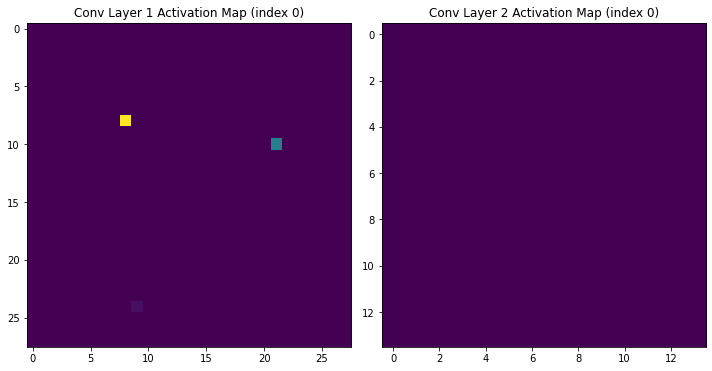

In [109]:
cnn_vanilla = CNN(epochs=epochs, variant='vanillaSGD')
train_loss, test_loss, train_acc, test_acc, first_epoch, last_epoch = cnn_vanilla.train(train_data, test_data)

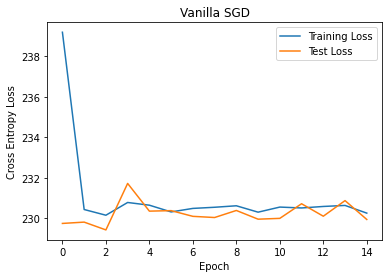

In [110]:
plot_loss(train_loss, test_loss, "Vanilla SGD")

Epoch 1
Train Accuracy: 8.5
Train Loss: 243.6424096750343
Test Accuracy: 11.0
Test Loss: 230.0152835374929

Epoch 2
Train Accuracy: 9.1
Train Loss: 230.78434030393979
Test Accuracy: 11.0
Test Loss: 231.02449425791787

Epoch 3
Train Accuracy: 11.4
Train Loss: 230.39490552972904
Test Accuracy: 6.0
Test Loss: 229.76888500665754

Epoch 4
Train Accuracy: 10.0
Train Loss: 230.36391001929735
Test Accuracy: 17.0
Test Loss: 229.80265401238805

Epoch 5
Train Accuracy: 10.9
Train Loss: 230.63234860032642
Test Accuracy: 13.0
Test Loss: 229.68428400742792

Epoch 6
Train Accuracy: 9.6
Train Loss: 230.44425365099212
Test Accuracy: 17.0
Test Loss: 229.6173535205917

Epoch 7
Train Accuracy: 9.6
Train Loss: 230.5132936966066
Test Accuracy: 6.0
Test Loss: 230.73235036299673

Epoch 8
Train Accuracy: 9.5
Train Loss: 230.48089112642197
Test Accuracy: 11.0
Test Loss: 229.7979132635231

Epoch 9
Train Accuracy: 9.8
Train Loss: 230.45584127477943
Test Accuracy: 13.0
Test Loss: 229.96217388769384

Epoch 10
Train

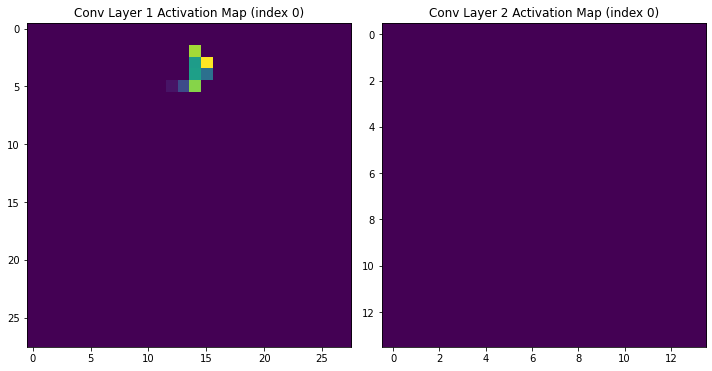

In [111]:
cnn_momentem = CNN(epochs=epochs, variant='momentum')
train_loss_momentum, test_loss_momentum, train_acc_momentum, test_acc_momentum, first_epoch_momentum, last_epoch_momentum = cnn_momentem.train(train_data, test_data)

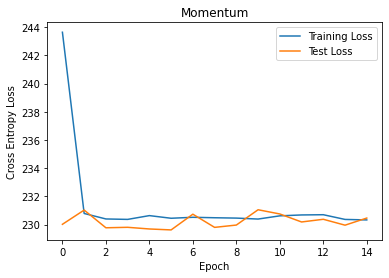

In [112]:
plot_loss(train_loss_momentum, test_loss_momentum, "Momentum")

Epoch 1
Train Accuracy: 10.5
Train Loss: 239.9550485875038
Test Accuracy: 4.0
Test Loss: 230.98238044781837

Epoch 2
Train Accuracy: 9.8
Train Loss: 230.4134938128255
Test Accuracy: 17.0
Test Loss: 229.73494425673303

Epoch 3
Train Accuracy: 9.8
Train Loss: 230.37731507617974
Test Accuracy: 4.0
Test Loss: 231.2364215367743

Epoch 4
Train Accuracy: 10.0
Train Loss: 230.31710343825532
Test Accuracy: 17.0
Test Loss: 230.34245351509733

Epoch 5
Train Accuracy: 9.5
Train Loss: 230.46558337418057
Test Accuracy: 17.0
Test Loss: 229.8991210050234

Epoch 6
Train Accuracy: 11.700000000000001
Train Loss: 230.25398124786508
Test Accuracy: 9.0
Test Loss: 230.51461901764984

Epoch 7
Train Accuracy: 10.7
Train Loss: 230.21036330302752
Test Accuracy: 11.0
Test Loss: 229.88644282229043

Epoch 8
Train Accuracy: 9.8
Train Loss: 230.35368366439778
Test Accuracy: 13.0
Test Loss: 230.3509372441849

Epoch 9
Train Accuracy: 9.2
Train Loss: 230.37360353572532
Test Accuracy: 11.0
Test Loss: 231.2406038436896

E

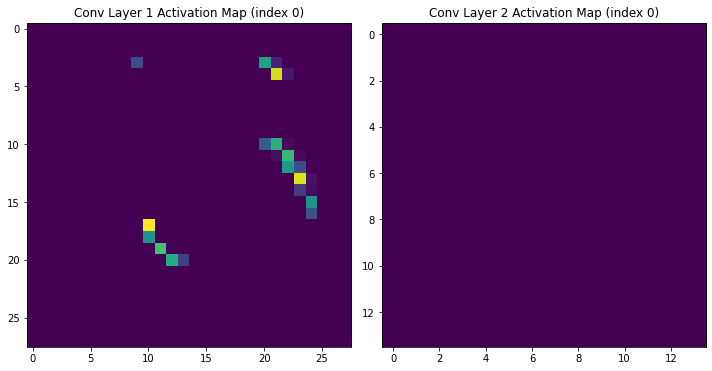

In [113]:
cnn_rms = CNN(epochs=epochs, variant='RMSProp')
train_loss_rms, test_loss_rms, train_acc_rms, test_acc_rms, first_epoch_rms, last_epoch_rms = cnn_rms.train(train_data, test_data)

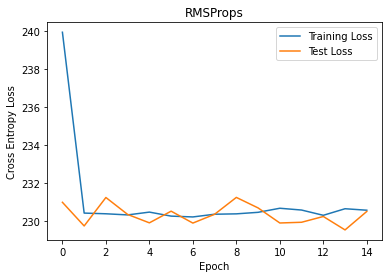

In [114]:
plot_loss(train_loss_rms, test_loss_rms, "RMSProps")

## t-SNE Plots

In [115]:
# The assignment document mentioned we are allowed to use open source code for the t-SNE plots.
# Hence, the t-SNE code was referenced from the following website: 
# https://www.datatechnotes.com/2020/11/tsne-visualization-example-in-python.html
def plot_tsne(values, plot_title, state):
  # flatten_values, labels,
  flatten_values = np.zeros((len(values), values[0][0].shape[0]))
  labels = np.zeros(len(values))
  for i in range(len(values)):
    flatten_values[i] = values[i][0]
    labels[i] = values[i][1]

  tsne = TSNE(n_components=2, random_state=state)
  z = tsne.fit_transform(flatten_values)
  df = pd.DataFrame()
  df["labels"] = labels
  df["comp-1"] = z[:,0]
  df["comp-2"] = z[:,1]

  sns.scatterplot(x="comp-1", y="comp-2", hue=df.labels.tolist(), palette=sns.color_palette("hls", 10), data=df).set(title=plot_title)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


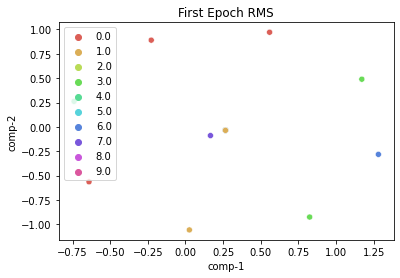

In [116]:
plot_tsne(first_epoch_rms, "First Epoch RMS", 46)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


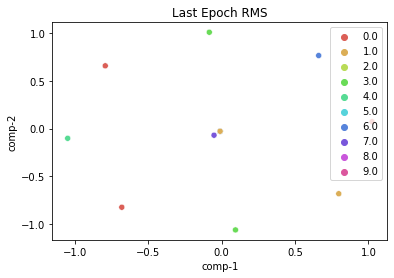

In [117]:
plot_tsne(last_epoch_rms, "Last Epoch RMS", 47)

# Observations 
When compare to the PyTorch implementation, the loss decreasess very arbritarily in the non-PyTorch version. Moreover, the accuracies are only comparable for the vanilla SGD update. For momentum and RMSProp, the PyTorch code outperforms its non-PyTorch counterpart by leaps and bounds. Lastly, the loss is much higher in the non-PyTorch version as compared to the other.